In [9]:
# # The below line only needs to be executed once and only if you are NOT ON BINDER. This clones the github repository to your local or remote machine
# !git clone -b bounding_box_prompt https://github.com/javirk/europa_surface.git

In [8]:
# # we access the repository to import modules below
# # also ONLY IF NOT ON BINDER:
# %cd europa_surface

In [1]:
import base64
import torch
import cv2
import numpy as np
import supervision as sv
from segment_anything.bbox_prompt_mask_generator import SamBBoxMaskGenerator
from segment_anything import sam_model_registry

IS_COLAB = False

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

ModuleNotFoundError: No module named 'supervision'

Helper function that loads an image before adding it to the widget

In [4]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

With the following cell, we download the weights from https://drive.google.com/file/d/1D2K2CC_aQMAv1qu0JQKt1Y-hllFzNdpQ/view?usp=drive_link

In [5]:
!pip install gdown

import gdown

file_id = "1D2K2CC_aQMAv1qu0JQKt1Y-hllFzNdpQ"  # the file's ID
output_file = "ck.pt"  

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Downloading...
From (original): https://drive.google.com/uc?id=1D2K2CC_aQMAv1qu0JQKt1Y-hllFzNdpQ
From (redirected): https://drive.google.com/uc?id=1D2K2CC_aQMAv1qu0JQKt1Y-hllFzNdpQ&confirm=t&uuid=6759dd78-5da3-40d0-a5c1-0880f04cba6f
To: z:\Groups\PIG\Caroline\lineament_detection\Reinforcement_Learning_SAM\europa_surface\ck.pt
100%|██████████| 364M/364M [00:07<00:00, 48.3MB/s] 


'ck.pt'

In [11]:
import requests

# LineaMapper v1.0 weights: from Mendeley data repo
url = "https://data.mendeley.com/public-files/datasets/nxnwj6hy4s/files/b248180d-aacb-43b4-a541-0b60d8076a3e/file_downloaded"

# Download the file
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Save the file locally
with open("Weights_v1_0.pt", "wb") as file:
    file.write(response.content)

In [7]:
# some users might need to run the following cell:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


Annotate the bounding box

In [13]:
# here, you can define any path to an image that you would like to try out
# select one of the below lines by toggling the # commenting hashtag or define your own
# IMAGE_PATH = "./demo/17ESREGMAP02_test_demo1.png"
IMAGE_PATH = "./demo/17ESREGMAP02_test_demo2.png"
# IMAGE_PATH = "./demo/17ESREGMAP02_test_demo3.png"
# IMAGE_PATH = "your/path/goes/here"


In [21]:
# setup the widget
widget = BBoxWidget(classes=['band', 'ridge complex', 'double ridge', 'undifferentiated linea'])
widget.image = encode_image(IMAGE_PATH) # load the image

# display:
widget

BBoxWidget(classes=['band', 'ridge complex', 'double ridge', 'undifferentiated linea'], colors=['#1f77b4', '#f…

In [16]:
widget.bboxes

[{'x': 63, 'y': 11, 'width': 131, 'height': 138, 'label': ''},
 {'x': 25, 'y': 9, 'width': 26, 'height': 50, 'label': ''},
 {'x': 150, 'y': 174, 'width': 60, 'height': 48, 'label': ''}]

In [22]:
# default_box is going to be used if you have not drawn any box on image above
default_box = {'x': 26, 'y': 106, 'width': 50, 'height': 93, 'label': ''}

# we prepare the boxes for input to SAM
boxs = widget.bboxes if widget.bboxes else default_box
boxes = []
for box in boxs:
    mybox = torch.tensor([[
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ]])
    # the shape of mybox is torch.Size([1, 4])
    # we add to a list for stacking
    boxes.append(mybox)

# we stack them to one tensor of torch.Size([num_boxes, 4])
boxes = torch.concat(boxes, axis=0)

In [23]:
# we load the vit_b model
sam = sam_model_registry['vit_b'](checkpoint='./ck.pt', num_classes=5, image_size=224)
# we define the mask_generator
mask_generator = SamBBoxMaskGenerator(sam)

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# we get a predicted mask on the drawn bounding boxes
sam_result = mask_generator.generate(image_rgb, boxes)

## Visualization

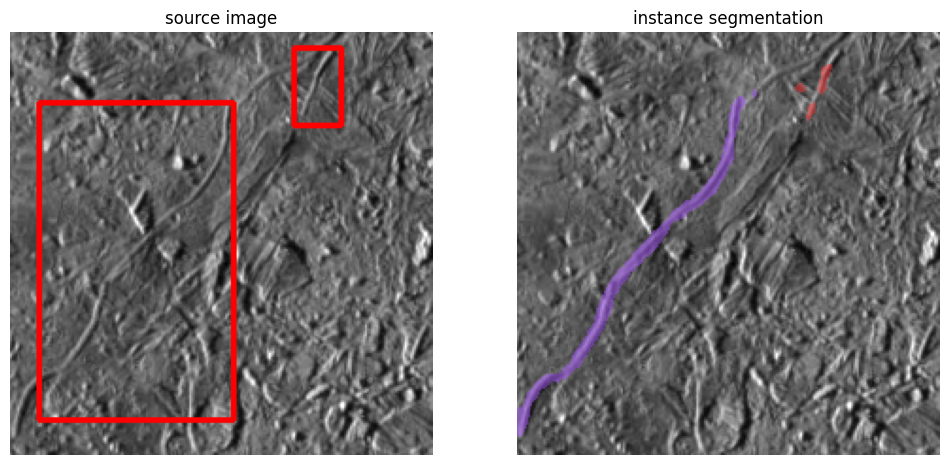

In [24]:
instances = (sam_result['segmentation'][:, 1:].sum(axis=1) > 0)
box_annotator = sv.BoundingBoxAnnotator(color=sv.Color.RED)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

instance_detections = sv.Detections(xyxy=boxes.numpy(), mask=instances, class_id=np.zeros(len(boxes)))
annotated_image_semantic = mask_annotator.annotate(scene=image_rgb.copy(), detections=instance_detections)
inp = box_annotator.annotate(scene=image_rgb.copy(), detections=instance_detections)

sv.plot_images_grid(
    images=[inp, annotated_image_semantic],
    grid_size=(1, 2),
    titles=['source image', 'instance segmentation'],
)

In [50]:
instance_detections

Detections(xyxy=array([[  0,  90, 189, 223],
       [135,  25, 159, 191],
       [ 49,  30,  69,  73],
       [ 73,  67,  93, 147],
       [ 88,  83, 222, 220]], dtype=int64), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False,

In [26]:
# we can print the result 
sam_result
# sam_result is a dictionary with the segmentations (binary and logits_mask), the predicted iou, and the input bounding boxes
# sam_result.keys() --> dict_keys(['segmentation', 'logits_mask', 'bbox', 'predicted_iou'])

{'segmentation': array([[[[ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          ...,
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True]],
 
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
 
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, Fals